# Inferential Statistics Ib - Frequentism

## Learning objectives

Welcome to the second Frequentist inference mini-project! Over the course of working on this mini-project and the previous frequentist mini-project, you'll learn the fundamental concepts associated with frequentist inference. The following list includes the topics you will become familiar with as you work through these two mini-projects:
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

## Prerequisites

* what a random variable is
* what a probability density function (pdf) is
* what the cumulative density function is
* a high-level sense of what the Normal distribution

If these concepts are new to you, please take a few moments to Google these topics in order to get a sense of what they are and how you might use them.

These two notebooks were designed to bridge the gap between having a basic understanding of probability and random variables and being able to apply these concepts in Python. This second frequentist inference mini-project focuses on a real-world application of this type of inference to give you further practice using these concepts. 

In the previous notebook, we used only data from a known normal distribution. You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.

## Hospital medical charges

Imagine that a hospital has hired you as their data analyst. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. This mini-project, as well as the bootstrap and Bayesian inference mini-projects also found in this unit are designed to illustrate how each of the inferential statistics methods have their uses for different use cases. In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?
Answering that last question with a frequentist approach makes some assumptions, or requires some knowledge, about the two groups. In the next mini-project, you'll use bootstrapping to test that assumption. And in the final mini-project of the unit, you're going to create a model for simulating _individual_ charges (not a sampling distribution) that the hospital can use to model a range of scenarios.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). For the purposes of this exercise, assume the observations are the result of random sampling from our one hospital. Recall in the previous assignment, we introduced the Central Limit Theorem (CLT), and how it tells us that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data. Remember, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy import stats
from numpy.random import seed
medical = pd.read_csv('data/insurance2.csv')

In [30]:
medical.shape

(1338, 8)

In [31]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__

        mean of charges = 13270.422265141257
        std dev of charges = 12105.484975561605
        The histogram shows that the data is heavily left skewed. 
        Hence statistics mean and standard deviation will not be able to provide a description of this data
        Expectedly, the box plot shows too many outliers.
        This could mean that there is a selection bias or possibly there is uneven charging of the patients

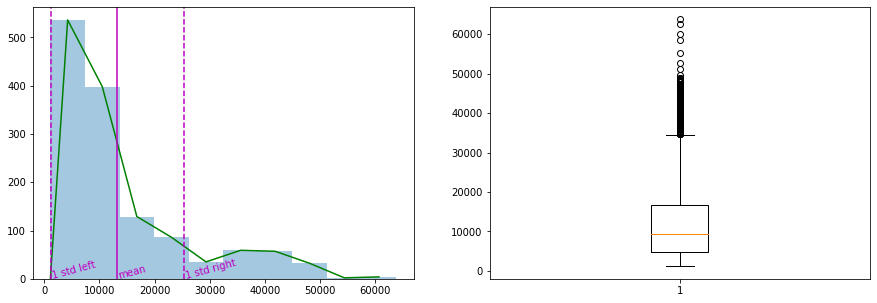

In [32]:
plt.figure(figsize=(15,5))

#Histogram of charges
plt.subplot(1,2,1)
#define a function for the histogram for use in a later context
def hist(data=medical['charges']):
    heights, binedges, _ = plt.hist(data, alpha=0.4)
    bincenters = 0.5*(binedges[1:]+binedges[:-1])
    bincenters = np.insert(bincenters, 0, binedges[0])
    heights = np.insert(heights, 0, 0.)
    _ = plt.plot(bincenters, heights,color='g')
    m  = np.mean(data)
    s1 = m - np.std(data)
    s2 = m + np.std(data)
    _ = plt.axvline(m, color='m')
    plt.text(m, 0, 'mean', rotation=15, color='m')
    _ = plt.axvline(s1, color='m', ls='--')
    plt.text(s1, 0, '1 std left', rotation=15, color='m')
    _ = plt.axvline(s2, color='m', ls='--')
    plt.text(s2, 0, '1 std right', rotation=15, color='m')
hist()
#boxplot of charges
plt.subplot(1,2,2)
_ = plt.boxplot(medical['charges'])

In [33]:
#mean
mean_charges = np.mean(medical['charges'])
print("mean of charges = {}".format(mean_charges))

#standard deviation
std_charges = np.std(medical['charges'])
print("std dev of charges = {}".format(std_charges))

mean of charges = 13270.422265141257
std dev of charges = 12105.484975561605


__Q:__ The administrator is concerned that the actual average charge has fallen below 12000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__ On the assumption that these data represent a random sample of charges, the observed mean of the sample 13270 is above the administrator's "concern" value of 12000. A 95% confidence test can be applied to check

__Q:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A one-sided or two-sided interval? Calculate the critical value and the relevant 95% confidence interval for the mean and comment on whether the administrator should be concerned?

__A:__ Since the administrator's concern is that the actual average charge has fallen below 12000, I'd go for a one sided interval which tries to predict with 95% confidence if 50% of the values lie below the mean and 45% above it

        Comments on administrator's concern:
        12000 falls within the 95% critical value of 13641.61293351335. Hence the null can be rejected.
        The administrator's concern is not significant.
        The actual average charge was found with a 95% confidence to be 13641.61293351335

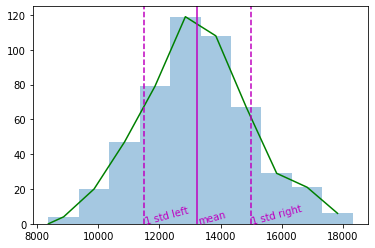

In [34]:
seed(47)
#Create a population of 100000 patients for the mean and standard deviation of the charges of the sample obtained 
#As we are extending the sample statistics into the population, we'll use a standard deviation with degrees of freedom n-1
std_charges_pop = np.std(medical['charges'], ddof=1)
pop_charges = np.random.normal(mean_charges, std_charges_pop, size=100000)

#Define a charges sampler
def charges_sampler(n):
    return np.random.choice(pop_charges, n)

#Define a mean of n sample trials
def mean_sample(n=50):
    return np.mean(charges_sampler(n))

#Sample 50 means 500 times from the population created above
samp_dist_500 = np.array([mean_sample() for _ in range(500)])

#plot histogram of the sample and mark the mean and standard deviation
hist(samp_dist_500)

In [35]:
#The plot above was made under the CLT assumption that under large number of sampling the data approaches normal even
#if the underlying population itself is not normal

#Since the administrator's concern is that the average charge is less that 12000, we'll check using a one sided 95% confidence
#interval

#mean of the sampling distribution
mean_samp_dist_500 = np.mean(samp_dist_500)
#standard deviation of the sampling distribution
std_samp_dist_500 = np.std(samp_dist_500)

#Null hypothesis: The actual average charge is less that 12000

#In a one sided interval we can get 95% coverage with 50% below the mean and 45% above the mean.
#For a standard normal distribution the value which corresponds to 50% below the mean is −∞. 
#45% of the population above the mean is 1.64 (refer z table)
#Using the above, the upper limit to the confidence interval is:
upper_conf = mean_samp_dist_500 + 1.64 * std_samp_dist_500/np.sqrt(50) #there are 50 means in a sample
if upper_conf > 12000:
    print("12000 falls within the 95% critical value of {}. Hence the null can be rejected.".format(upper_conf))
    print("The administrator's concern is not significant.")
    print("The actual average charge was found with a 95% confidence to be {}".format(upper_conf))
else:
    print("12000 does not fall within the 95% critical value of {}. Hence the null cannot be rejected.".format(upper_conf) )
    print("The administrator's concern is significant!")
    print("The actual average charge was found with a 95% confidence to be {}".format(upper_conf))

12000 falls within the 95% critical value of 13641.61293351335. Hence the null can be rejected.
The administrator's concern is not significant.
The actual average charge was found with a 95% confidence to be 13641.61293351335


The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means where the pooled standard deviation of the two groups is given by
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t* test statistic is then given by

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

What assumption about the variances of the two groups are we making here?

__A:__ The null hypothesis is that the people with insurance are charged the same amount to those without(μ0=μ1).
       The alternate hypothesis is that the people with insurance are charged differently from those without(μ0≠μ1).  
       The assumption is that the variances of the two groups are equal

__Q:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

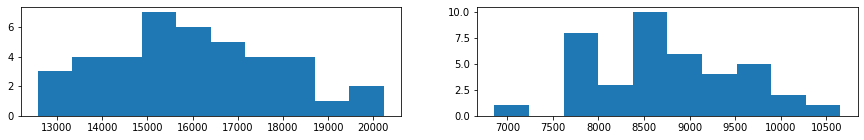

In [36]:
#Separate ins(insurance) and noins(without insurance) data
ins, noins = medical[medical['insuranceclaim'] == 1], medical[medical['insuranceclaim'] == 0]

#Calculate means and standard deviations
ins_mean = np.mean(ins['charges'])
ins_std = np.std(ins['charges'], ddof=1) #estimate of the population

noins_mean = np.mean(noins['charges'])
noins_std = np.std(noins['charges'], ddof=1) #estimate of the population

#Create a normalized population distribution of ins and noins
seed(47)
pop_ins = np.random.normal(ins_mean, ins_std, size=50000)
pop_noins = np.random.normal(noins_mean, noins_std, size=50000)

#Sample 50 means 40 times from the population for the t distribution
seed(47)
ins_samp_dist_t = np.array([np.mean(np.random.choice(pop_ins, 50)) for _ in range(40)])
noins_samp_dist_t = np.array([np.mean(np.random.choice(pop_noins, 50)) for _ in range(40)])

#plot the t distributions
plt.figure(figsize=(15,2))
plt.subplot(1,2,1)
ins_heights_t, ins_binedges_t, ins_patches_t = plt.hist(ins_samp_dist_t)

plt.subplot(1,2,2)
noins_heights_t, noins_binedges_t, noins_patches_t = plt.hist(noins_samp_dist_t)

In [37]:
#means of the samples
x0 = np.mean(ins_samp_dist_t)
x1 = np.mean(noins_samp_dist_t)
#standard deviations of the samples
s0 = np.std(ins_samp_dist_t)
s1 = np.std(noins_samp_dist_t)

#pooled standard deviation
sp = np.sqrt((s0**2 + s1**2)/2) #n0 = n1 = 40

#pooled t-statistic
ts = (x0-x1)/(sp*np.sqrt(2/40))

print("t-statistic = {}".format(ts))


t-statistic = 22.876826318381138


In [44]:
#for t-statistic 22.8768, for 78 (40+40-2) degrees of freedom 
pval = (1 - t.cdf(22.876826318381138, 78)) * 2
print("pval = {}".format(pval))

# pval is too small that a value 0 is returned. Trying the t-table, the two tailed t-table doesn't have a value.
#for a t-statistic 3.46 however, for 80 degrees of freedom, the two tailed t-tabe has a value 0.001. 
#Hence our pvalue is understood to be extremely low and the null can be rejected

pval = 0.0


In [43]:
stats.ttest_ind_from_stats(x0, s0, 40, x1, s1, 40)

Ttest_indResult(statistic=22.876826318381138, pvalue=2.4525066183289764e-36)

Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do pass your data to it.

__Q:__ In the above calculations, we assumed the sample variances were equal. We may well suspect they are not (we'll explore this in another assignment). The calculation becomes a little more complicated to do by hand in this case, but we now know of a helpful function. Check the documentation for the function to tell it not to assume equal variances and perform the test again.

__A:__ the t-statistic remains the same with the assumption of unequal variances, but the p-value increases slightly. Yet, the null is to be rejected

In [46]:
#when equal variances are not assumed
stats.ttest_ind_from_stats(x0, s0, 40, x1, s1, 40, equal_var=False)

Ttest_indResult(statistic=22.876826318381138, pvalue=5.133797726797438e-29)

__Q:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__ The pooled vairances are calculated for small samples and hence only t-test can be applied 

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test